In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
import seaborn as sns
import pandas as pd
from labproject.metrics.wasserstein_sinkhorn import sinkhorn_loss,sinkhorn_algorithm
from labproject.metrics.wasserstein_kuhn import kuhn_transport
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
from labproject.metrics.MMD_torch import compute_rbf_mmd,compute_rbf_mmd_median_heuristic,median_heuristic
from labproject.data import get_distribution
from labproject.utils import set_seed
from dataclasses import dataclass

set_seed(0)



0

In [2]:
#Base distribution
toy_data = get_distribution("toy_2d")
MOG = toy_data()


In [3]:
dpi = 150
plt.style.use("../../matplotlibrc")
plt.rcParams.update({"figure.dpi": dpi})



@dataclass
class FigureLayout:
    width_in_pt: float
    width_grid: int
    base_font_size: int = 8
    scale_factor: float = 1.0

    # matplotlib uses inch
    def _get_grid_in_inch(self, w_grid, h_grid):
        pt_to_inch = 1 / 72
        assert w_grid <= self.width_grid
        return (
            (w_grid / self.width_grid) * self.width_in_pt * pt_to_inch,
            (h_grid / self.width_grid) * self.width_in_pt * pt_to_inch,
        )

    def get_rc(self, w_grid, h_grid):
        return {
            "figure.figsize": self._get_grid_in_inch(w_grid, h_grid),
            "font.size": self.base_font_size * self.scale_factor,
        }
    
textwidth=469
fig_handler = FigureLayout(469,100)
params = fig_handler.get_rc(40,30)
plt.rcParams.update(params)


In [4]:
class Gauss(nn.Module):
    def __init__(self,dim):
        super(Gauss, self).__init__()
        self.mean = nn.Parameter(torch.zeros(dim))
        self.lower_triangular = nn.Parameter(torch.ones(dim*(dim+1)//2))
        self._row_ix, self._column_ix = torch.triu_indices(dim,dim)
        self.dim = dim

    def forward(self, noise):
        sample = self.cov_lt().matmul(noise.transpose(-2,-1)).transpose(-2,-1) + self.mean.unsqueeze(0)
        return sample
    
    def sample(self,size):
        return self.forward(torch.randn(size, self.dim))
    
    def cov(self):
        return self.cov_lt().matmul(self.cov_lt().transpose(-2,-1))
    
    def cov_lt(self):
        cov = torch.zeros(self.dim,self.dim)
        cov[self._row_ix,self._column_ix] = self.lower_triangular
        return cov






In [5]:
num_samples = 1000

bws =  []
for dim in range(1,100):
    uniform_samples1 = torch.from_numpy(np.random.normal(size=(num_samples, dim)))
    uniform_samples2 = torch.from_numpy(np.random.normal(size=(num_samples, dim)))
    bandwidth = median_heuristic(uniform_samples1, uniform_samples2).detach()
    print(np.sqrt(2*dim), bandwidth)
    bws.append(bws)

1.0 tensor(0.9336, dtype=torch.float64)
1.4142135623730951 tensor(1.6558, dtype=torch.float64)
1.7320508075688772 tensor(2.1610, dtype=torch.float64)
2.0 tensor(2.5676, dtype=torch.float64)
2.23606797749979 tensor(2.9426, dtype=torch.float64)
2.449489742783178 tensor(3.2708, dtype=torch.float64)
2.6457513110645907 tensor(3.5698, dtype=torch.float64)
2.8284271247461903 tensor(3.8117, dtype=torch.float64)
3.0 tensor(4.0733, dtype=torch.float64)
3.1622776601683795 tensor(4.3199, dtype=torch.float64)
3.3166247903554 tensor(4.5416, dtype=torch.float64)
3.4641016151377544 tensor(4.7465, dtype=torch.float64)
3.605551275463989 tensor(4.9426, dtype=torch.float64)
3.7416573867739413 tensor(5.1945, dtype=torch.float64)
3.872983346207417 tensor(5.3483, dtype=torch.float64)
4.0 tensor(5.5200, dtype=torch.float64)
4.123105625617661 tensor(5.7578, dtype=torch.float64)
4.242640687119285 tensor(5.8726, dtype=torch.float64)
4.358898943540674 tensor(6.0302, dtype=torch.float64)
4.47213595499958 tensor(6.

/tmp/ipykernel_46508/1875527804.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)


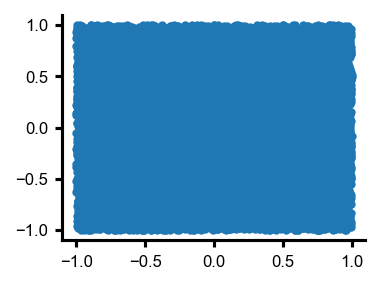

In [6]:
num_samples = 12000
uniform_samples = np.random.uniform(-1, 1, size=(num_samples, 2))
uniform_samples = torch.tensor(uniform_samples, dtype=torch.float32)

mean1, mean2 = (0.7, 0), (-.7, 0)  # Means in 2D, y-coordinate is 0 for both
variance1 = 0.04
variance2 = 0.04

# Generate samples from the mixture of 2D Gaussians
mixture_samples =MOG.sample(num_samples)
mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)
plt.scatter(uniform_samples[:, 0], uniform_samples[:, 1], label="Uniform")

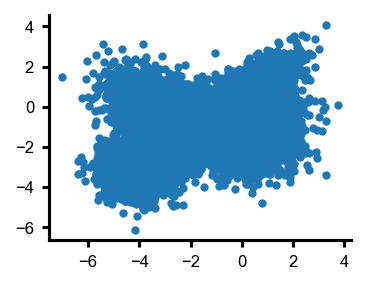

In [7]:
plt.scatter(mixture_samples[:, 0], mixture_samples[:, 1], label="Mixture of Gaussians")

In [8]:
# Fit the Gauss model to the data using sliced Wasserstein distance

# mean = torch.tensor([0.0, 0.0], requires_grad=True)
# cov = torch.tensor([[1.0 , 0.0], [0.0, 1.0]], requires_grad=True)
# mvn = torch.distributions.MultivariateNormal(torch.zeros_like(mean), torch.diag(torch.ones_like(mean)))
# data.requires_grad_()
# print(data)

gauss_model = Gauss(dim=2)

with torch.no_grad():
    samples = gauss_model.sample(num_samples)
    bandwidth =median_heuristic(mixture_samples, uniform_samples)
    print("bandwidth: ", bandwidth)
optimizer = torch.optim.Adam(gauss_model.parameters(), lr=0.1)
gauss_model.train()
num_epochs = 20
for epoch in range(num_epochs):
    gauss_model.zero_grad()
    samples = gauss_model.sample(num_samples)
    #print(samples)
    loss = compute_rbf_mmd(samples, uniform_samples, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model.eval()



bandwidth:  tensor(2.5399)
Iter: 0     loss: 0.036928653717041016
Iter: 1     loss: 0.026840567588806152
Iter: 2     loss: 0.015748023986816406
Iter: 3     loss: 0.00840449333190918
Iter: 4     loss: 0.0051506757736206055
Iter: 5     loss: 0.0028711557388305664
Iter: 6     loss: 0.0013432502746582031
Iter: 7     loss: 0.0011676549911499023
Iter: 8     loss: 0.002132415771484375


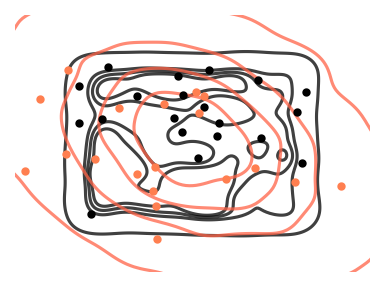

In [ ]:
SWD_samples = gauss_model.sample(num_samples).detach().numpy()
# Create a dataframe for the mixture samples
unif_df = pd.DataFrame({'x': uniform_samples[:, 0], 'y': uniform_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
SWD_df = pd.DataFrame({'x': SWD_samples[:, 0], 'y': SWD_samples[:, 1]})

# Plot the probability contours
fig,ax = plt.subplots()
sns.kdeplot(ax=ax,data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=ax,data=SWD_df, x='x', y='y', fill=False, color="tomato",alpha=0.75, levels=5)

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
ax.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
fig.tight_layout()


In [ ]:
gauss_model_WS = Gauss(dim=2)
gauss_model_MMD = Gauss(dim=2)

with torch.no_grad():
    samples = gauss_model.sample(num_samples)
    bandwidth = median_heuristic(samples,mixture_samples)
    print("bandwidth: ", bandwidth)



bandwidth:  tensor(0.1692)


In [ ]:
# Fit the Gauss model to the data using sliced Wasserstein distance

# mean = torch.tensor([0.0, 0.0], requires_grad=True)
# cov = torch.tensor([[1.0 , 0.0], [0.0, 1.0]], requires_grad=True)
# mvn = torch.distributions.MultivariateNormal(torch.zeros_like(mean), torch.diag(torch.ones_like(mean)))
# data.requires_grad_()
# print(data)
optimizer = torch.optim.Adam(gauss_model2.parameters(), lr=0.1)
gauss_model2.train()
num_epochs = 100
for epoch in range(num_epochs):
    gauss_model2.zero_grad()
    samples = gauss_model2.sample(num_samples)
    #print(samples)
    loss = compute_rbf_mmd(samples, mixture_samples, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model2.eval()



Iter: 0     loss: 0.00534485001116991
Iter: 1     loss: 0.004152107983827591
Iter: 2     loss: 0.003390551544725895
Iter: 3     loss: 0.002710440196096897
Iter: 4     loss: 0.0023628249764442444
Iter: 5     loss: 0.0020535625517368317
Iter: 6     loss: 0.001960897818207741
Iter: 7     loss: 0.0018381616100668907
Iter: 8     loss: 0.0018025822937488556
Iter: 9     loss: 0.0017439424991607666
Iter: 10     loss: 0.0016628364101052284
Iter: 11     loss: 0.00164888147264719
Iter: 12     loss: 0.0015875427052378654
Iter: 13     loss: 0.001569651998579502
Iter: 14     loss: 0.0016389228403568268
Iter: 15     loss: 0.0016174064949154854
Iter: 16     loss: 0.0016324939206242561
Iter: 17     loss: 0.0016438690945506096
Iter: 18     loss: 0.0016873609274625778
Iter: 19     loss: 0.001636863686144352
Iter: 20     loss: 0.0015716105699539185
Iter: 21     loss: 0.0016419198364019394
Iter: 22     loss: 0.001692947931587696
Iter: 23     loss: 0.0016577281057834625
Iter: 24     loss: 0.0016429973766207

KeyboardInterrupt: 

In [ ]:
SWD_mix_samples = gauss_model2.sample(num_samples).detach().numpy()

mixture_df = pd.DataFrame({'x': mixture_samples[:, 0], 'y': mixture_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
SWD_mix_df = pd.DataFrame({'x': SWD_mix_samples[:, 0], 'y': SWD_mix_samples[:, 1]})

# Plot the probability contours
fig,ax = plt.subplots()
sns.kdeplot(ax=ax,data=mixture_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=ax,data=SWD_mix_df, x='x', y='y', fill=False, color="tomato",alpha=0.75, levels=5)

permuted_mix_samples = mixture_samples[torch.randperm(num_samples)]

#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-1.0, 1.0)
ax.scatter(permuted_mix_samples[:20, 0], permuted_mix_samples[:20, 1], color="black",zorder=10)
ax.scatter(SWD_mix_samples[:20, 0], SWD_mix_samples[:20, 1], color="coral",zorder=10)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
fig.tight_layout()
#plt.savefig("MMD.png")

NameError: name 'gauss_model2' is not defined

In [ ]:
print("SWD_mean: ",gauss_model.mean.detach().numpy())
print("SWD_cov: ",gauss_model.cov().detach().numpy())
print("uniform data mean: ",uniform_samples.mean(dim=0).numpy())
print("uniform data cov: ",uniform_samples.T.cov().numpy())

SWD_mean:  [-0.00975406  0.00832371]
SWD_cov:  [[ 0.44918722 -0.12206161]
 [-0.12206161  0.57692784]]
uniform data mean:  [-0.00267119 -0.0171042 ]
uniform data cov:  [[0.34271112 0.00867608]
 [0.00867608 0.34278804]]


In [ ]:
print("SWD_mean: ",gauss_model2.mean.detach().numpy())
print("SWD_cov: ",gauss_model2.cov().detach().numpy())
print("mixture data mean: ",mixture_samples.mean(dim=0).numpy())
print("mixture data cov: ",mixture_samples.T.cov().numpy())

SWD_mean:  [-0.26451185  0.01485614]
SWD_cov:  [[0.82529294 0.0021447 ]
 [0.0021447  0.038281  ]]
mixture data mean:  [-0.1417305   0.01251941]
mixture data cov:  [[0.53172207 0.00548582]
 [0.00548582 0.03852978]]


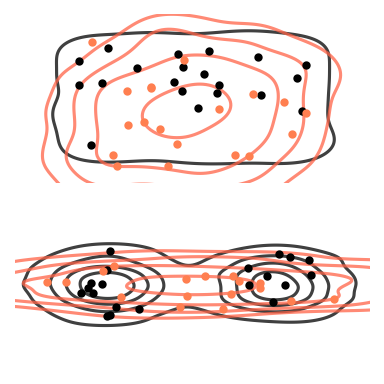

In [ ]:

params = fig_handler.get_rc(40,40)
plt.rcParams.update(params)
# Plot the probability contours
fig,axs = plt.subplots(2,1)
ax1,ax2 = axs
sns.kdeplot(ax=ax1,data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=[0.05])
sns.kdeplot(ax=ax1,data=SWD_df, x='x', y='y', fill=False, color="tomato",alpha=0.75, levels=[0.125,0.25,0.45,0.85])

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
ax1.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
ax1.spines[['left', 'bottom']].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("")
ax1.set_ylabel("")

sns.kdeplot(ax=ax2,data=mixture_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=ax2,data=SWD_mix_df, x='x', y='y', fill=False, color="tomato",alpha=0.75, levels=[0.125,0.25,0.45,0.85])

ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.0, 1.0)
ax2.scatter(permuted_mix_samples[:20, 0], permuted_mix_samples[:20, 1], color="black",zorder=10,label = r"$p_{\text{true}}$")
ax2.scatter(SWD_mix_samples[:20, 0], SWD_mix_samples[:20, 1], color="coral",zorder=10,label=r"$\hat{p}_{1}$")
ax2.spines[['left', 'bottom']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("")
ax2.set_ylabel("")

# ax2.legend(loc="upper center")

fig.tight_layout()
fig.savefig("../../plots/swd_misspecified_models.svg")
plt.show()

params = fig_handler.get_rc(40,30)
plt.rcParams.update(params)